# 1. Data Generation
- 시계열 데이터 준비
- 정규화 진행
- Sequence와 Label 생성
- Train, Test 데이터로 분리

## Overall Process
![](/home/jhbale11/TimeSeriesForecasting_WithPytorch/img/Process.png)

## Load Library

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
import os
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt

# matplotlib 설정
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

/home/jhbale11/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 코드 재생산을 위해 SEED를 고정하겠습니다.
SEED = 1345

os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load Stock Data
`yfinance` 라이브러리를 사용하여 삼성전자 주가 데이터를 불러옵니다.
- Ticker : 005930.KS
- 기간 : 2018.01.01 - 2023.02.01

In [3]:
import yfinance as yf

samsung_df = yf.download('005930.KS',
                      start='2018-01-01',
                      end='2023-02-01',
                      progress=False)
samsung_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,51380.0,51400.0,50780.0,51020.0,43994.203125,8474250
2018-01-03,52540.0,52560.0,51420.0,51620.0,44511.570312,10013500
2018-01-04,52120.0,52180.0,50640.0,51080.0,44045.929688,11695450
2018-01-05,51300.0,52120.0,51200.0,52120.0,44942.722656,9481150
2018-01-08,52400.0,52520.0,51500.0,52020.0,44856.503906,8383650
...,...,...,...,...,...,...
2023-01-25,63500.0,63700.0,63000.0,63300.0,63300.000000,39217
2023-01-26,63800.0,63900.0,63300.0,63800.0,63800.000000,54188
2023-01-27,64400.0,65000.0,63900.0,64600.0,64600.000000,44282


`pct_change()` 함수를 사용하여 종가에 대한 수익률을 반환합니다.

In [4]:
samsung_df = samsung_df['Close'].pct_change()
samsung_df = samsung_df.dropna()
samsung_df

Date
2018-01-03    0.011760
2018-01-04   -0.010461
2018-01-05    0.020360
2018-01-08   -0.001919
2018-01-09   -0.031142
                ...   
2023-01-25    0.024272
2023-01-26    0.007899
2023-01-27    0.012539
2023-01-30   -0.020124
2023-01-31   -0.030016
Name: Close, Length: 1249, dtype: float64

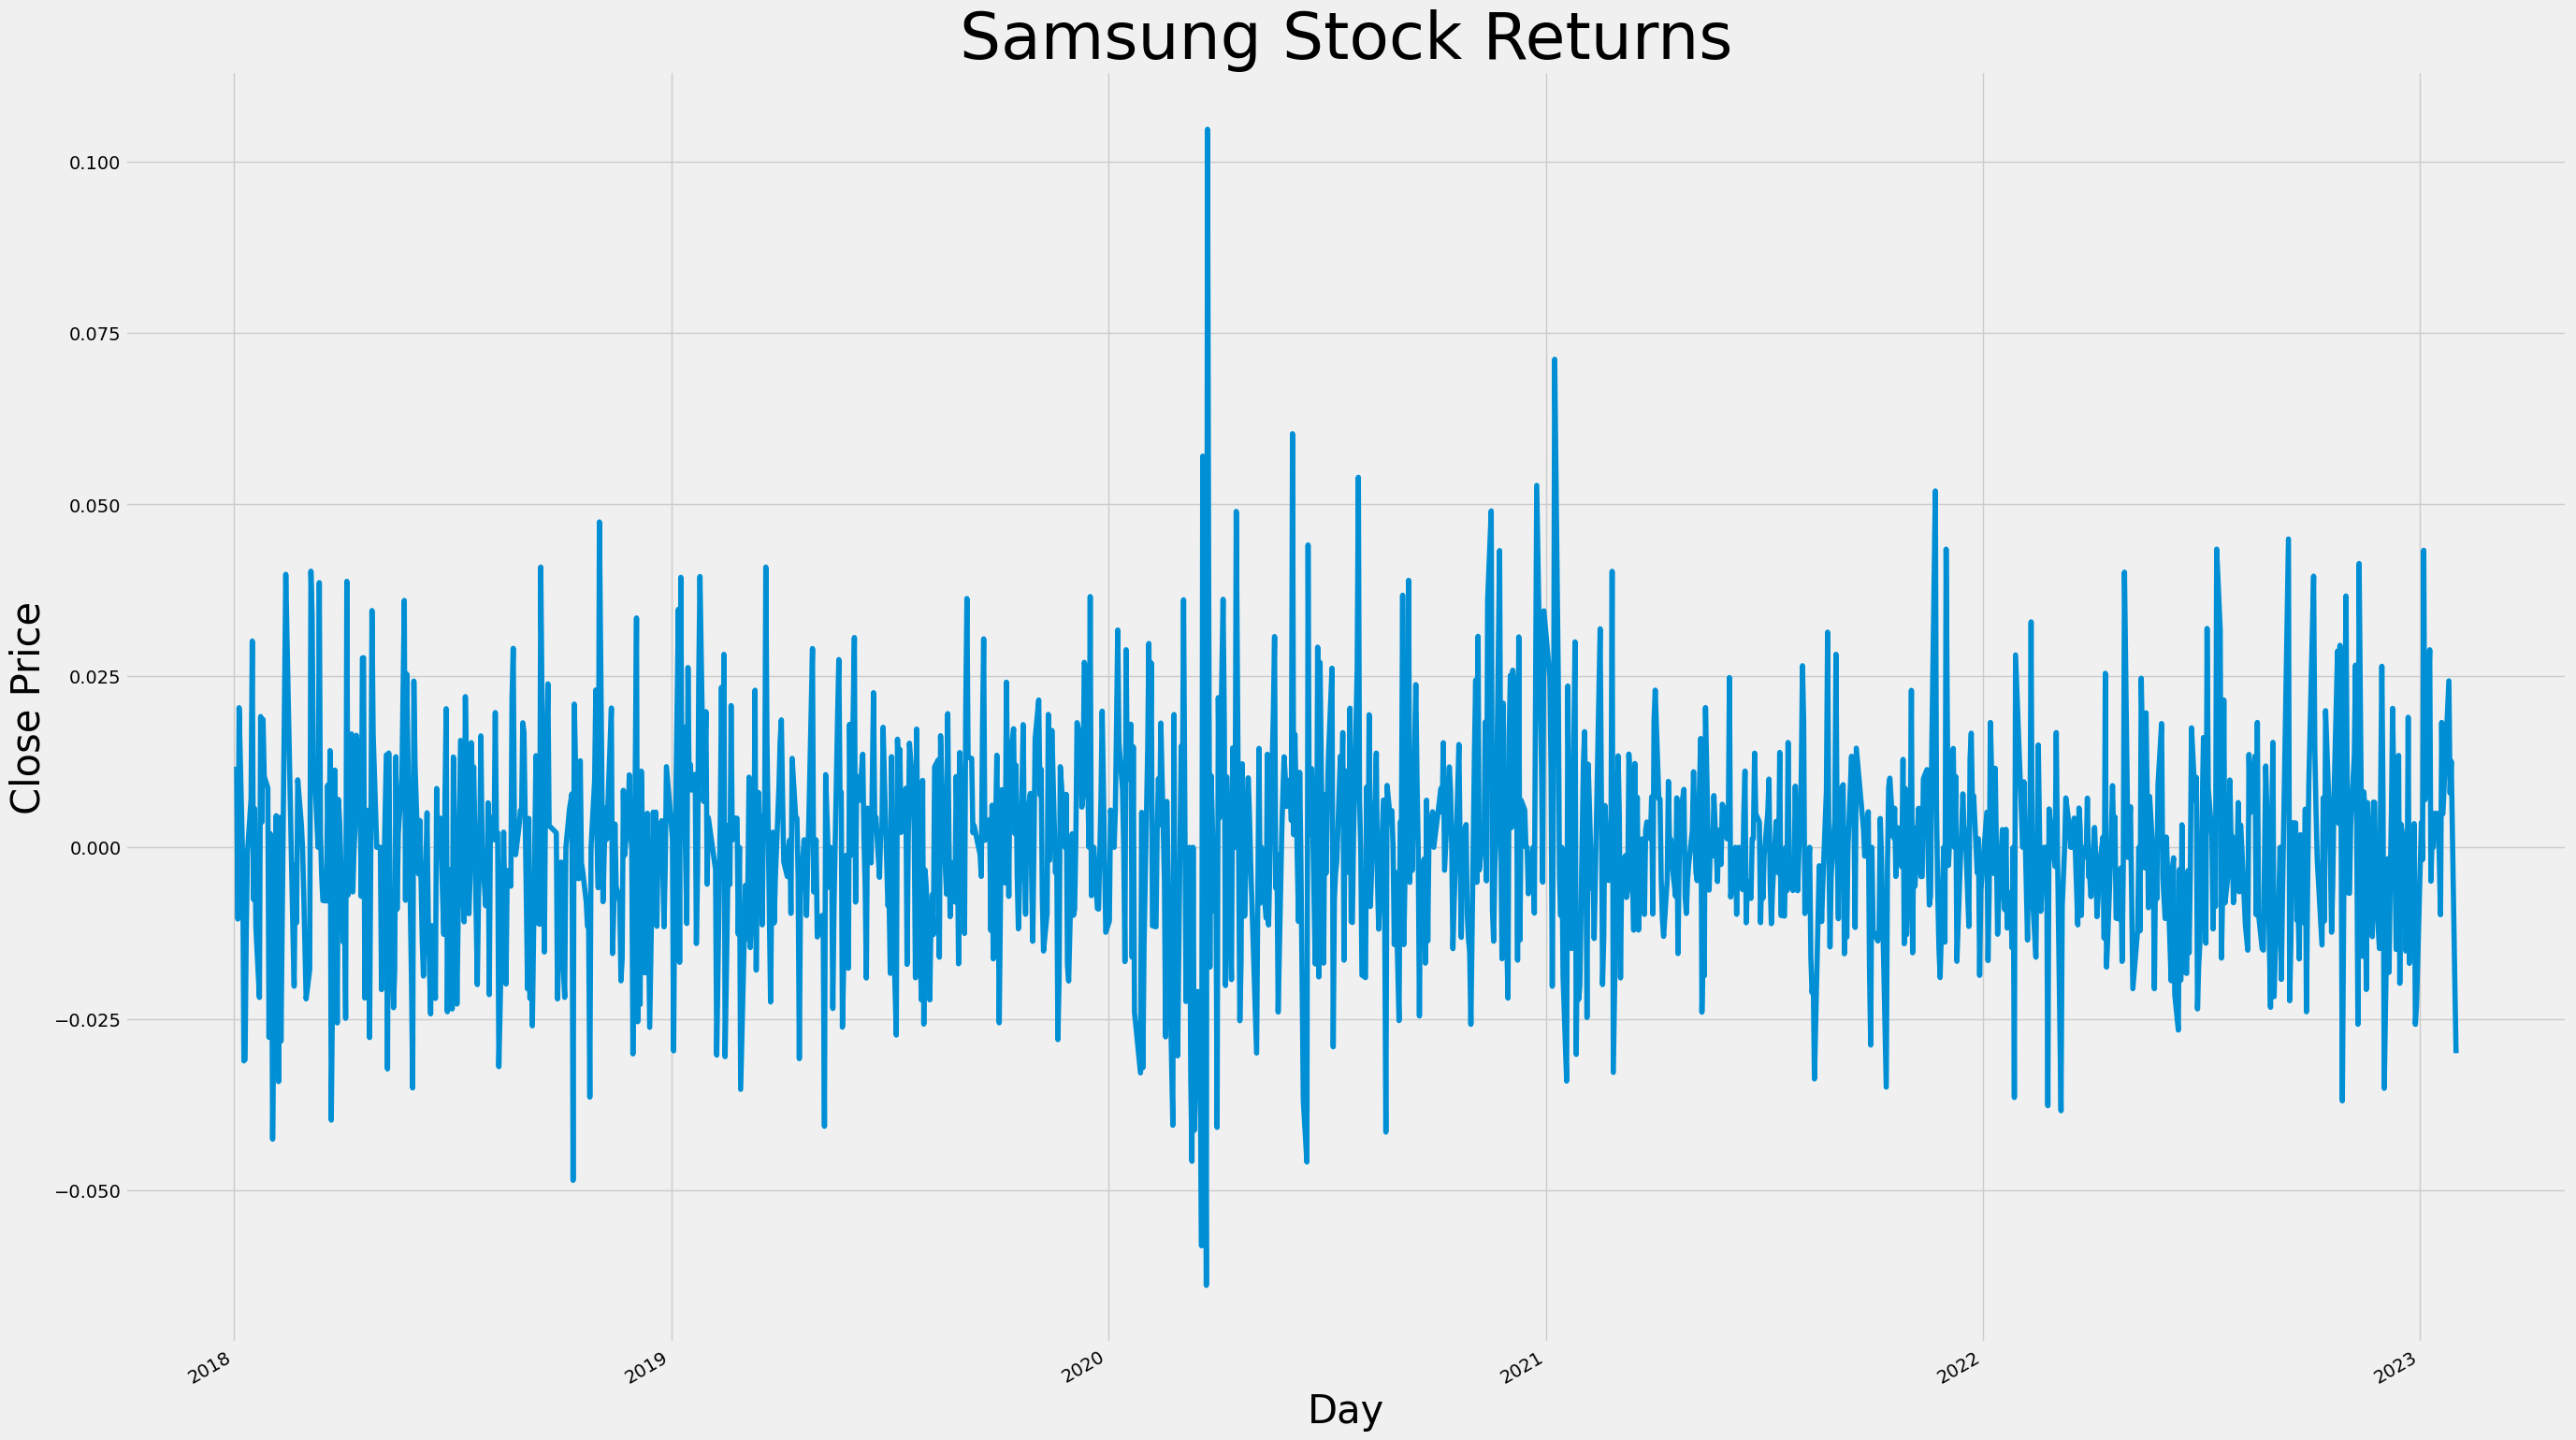

In [5]:
fig, ax = plt.subplots(figsize=(30, 20))
samsung_df.plot(ax=ax)
plt.title("Samsung Stock Returns",fontsize=50)
plt.xlabel('Day', fontsize=30)
plt.ylabel('Close Price', fontsize=30)
plt.show()

In [11]:
y = pd.DataFrame(samsung_df)
y.index = pd.to_datetime(y.index)
y.to_csv('./data/samsung_df.csv')
y

,Close
Date,
2018-01-03,0.011760
2018-01-04,-0.010461
2018-01-05,0.020360
2018-01-08,-0.001919
2018-01-09,-0.031142
...,...
2023-01-25,0.024272
2023-01-26,0.007899
2023-01-27,0.012539


## Normalize the Data

In [7]:
data = np.array(y)
scaler = MinMaxScaler(feature_range=(-1,1))
train_data_normalized = scaler.fit_transform(data.reshape(-1,1))
train_data_normalized

array([[-0.10267399],
       [-0.36629746],
       [-0.00064533],
       ...,
       [-0.09343115],
       [-0.48093303],
       [-0.59828752]])

In [8]:
# 이 함수는 28일로 이루어져 있는 sequences와 하루의 label을 생성합니다.
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [9]:
seq_length = 21
x, y = sliding_windows(train_data_normalized, seq_length)
print(x.shape)
print(y.shape)

(1227, 21, 1)
(1227, 1)


## About Generated Sequence

![](/home/jhbale11/TimeSeriesForecasting_WithPytorch/img/Sequence1-2.png)

In [10]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([981, 21, 1])
train label shape is: torch.Size([981, 1])
test shape is: torch.Size([246, 21, 1])
test label shape is: torch.Size([246, 1])


So we got :
- 981 sets of 21 samples each as the features (X) and 981 labels as our target(y) in the training set
- 246 sets of 21 samples with 246 labels in our tests set

You can see that in Pytorch the tensor dimensions are opposite to the NumPy dimensions